In [1]:

import csv
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import time
import random


In [2]:
#!/usr/bin/env python3
"""
Retail Markdown Game Simulator
==============================
This script automates playing the Retailer Game using predefined price markdown strategies.
It records results in two CSV files:
- week_detail.csv: Contains weekly data for each simulation
- outcome.csv: Contains final performance metrics for each simulation
"""

import csv
import time
import re
import pandas as pd
import itertools
from selenium import webdriver
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import TimeoutException, NoSuchElementException
import traceback
import os

# Game URL
GAME_URL = "https://www.randhawa.us/games/retailer/nyu.html"

def generate_price_strategies():
    """
    Generate all valid price markdown strategies and returns as a DataFrame.
    
    Returns:
        pandas.DataFrame: DataFrame with all valid price combinations
    """
    # All possible prices
    prices = [60, 54, 48, 36]
    
    # Generate all valid combinations (non-increasing prices)
    valid_combos = []
    combo_id = 0
    
    for combo in itertools.product(prices, repeat=14):
        # Check if prices are non-increasing
        if all(combo[i] >= combo[i+1] for i in range(13)):
            # First week is always 60
            full_combo = [combo_id, 60] + list(combo)
            valid_combos.append(full_combo)
            combo_id += 1
    
    # Create DataFrame
    columns = ["combo_number"] + [str(i) for i in range(1, 16)]
    df = pd.DataFrame(valid_combos, columns=columns)
    
    return df

def convert_to_actions(price_df):
    """
    Convert price values to action letters.
    
    Args:
        price_df: DataFrame with price values
        
    Returns:
        pandas.DataFrame: DataFrame with action letters
    """
    action_df = pd.DataFrame()
    action_df['combo_number'] = price_df['combo_number']
    
    # First week is always maintain (A)
    action_df['1'] = 'A'
    
    # For subsequent weeks, determine the action based on price change
    for week in range(2, 16):
        curr_week = str(week)
        prev_week = str(week - 1)
        
        actions = []
        for _, row in price_df.iterrows():
            prev_price = row[prev_week]
            curr_price = row[curr_week]
            
            if curr_price == prev_price:
                action = 'A'  # Maintain
            elif curr_price == 54:
                action = 'B'  # 10% markdown
            elif curr_price == 48:
                action = 'C'  # 20% markdown
            elif curr_price == 36:
                action = 'D'  # 40% markdown
            else:
                action = '?'  # Unknown (shouldn't happen)
                
            actions.append(action)
            
        action_df[curr_week] = actions
    
    return action_df

def setup_browser():
    """
    Set up and return a configured browser instance.
    
    Returns:
        webdriver.Chrome: Configured Chrome WebDriver
    """
    chrome_options = Options()
    # Uncomment to run headless (no GUI)
    chrome_options.add_argument("--headless")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--window-size=1920x1080")
    chrome_options.add_argument("--no-sandbox")
    chrome_options.add_argument("--disable-dev-shm-usage")
    # Performance optimizations
    chrome_options.add_argument("--disable-extensions")
    chrome_options.add_argument("--disable-images")
    chrome_options.add_argument("--blink-settings=imagesEnabled=false")
    chrome_options.page_load_strategy = 'eager'
    
    # Initialize the browser
    try:
        # If using webdriver_manager
        from webdriver_manager.chrome import ChromeDriverManager
        browser = webdriver.Chrome(service=Service(ChromeDriverManager().install()), options=chrome_options)
    except:
        # Fallback to local chromedriver
        browser = webdriver.Chrome(options=chrome_options)
    
    # Set shorter timeouts
    browser.set_page_load_timeout(5)
    browser.set_script_timeout(5)
        
    # Navigate to the game and maximize window
    browser.get(GAME_URL)
    browser.maximize_window()
    
    return browser

def run_simulation(browser, combo_row, simulation_number):
    """
    Run a single simulation using the specified pricing strategy.
    
    Args:
        browser: WebDriver instance
        combo_row: DataFrame row with actions for each week
        simulation_number: Identifier for this simulation
    
    Returns:
        tuple: (week_data, outcome_data) containing results
    """
    wait = WebDriverWait(browser, 2)
    
    # Map letters to button IDs
    action_map = {
        'A': 'maintainButton',  # Maintain price
        'B': 'tenButton',       # 10% markdown
        'C': 'twentyButton',    # 20% markdown
        'D': 'fortyButton'      # 40% markdown
    }
    
    # Click the "Start Game" button
    try:
        start_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#practiceButton")))
        start_button.click()
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#result-table tr:nth-child(2)")))
    except Exception as e:
        # If error, refresh and try again
        print(f"Error starting game, refreshing page: {e}")
        browser.refresh()
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#practiceButton")))
        start_button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, "#practiceButton")))
        start_button.click()
        wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#result-table tr:nth-child(2)")))
    
    combo_id = int(combo_row['combo_number'])
    week_data = []
    
    # Execute the strategy for weeks 2-15 (week 1 is automatic)
    for week in range(2, 16):
        try:
            week_str = str(week)
            action_letter = combo_row[week_str]
            button_id = action_map[action_letter]
            
            # Wait for and click the appropriate button using CSS selector
            button = wait.until(EC.element_to_be_clickable((By.CSS_SELECTOR, f"#{button_id}")))
            button.click()
            
        except TimeoutException:
            # Some actions might be disabled due to previous choices
            continue
        except Exception as e:
            continue
    
    # Wait for final results
    wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#rev")))
    
    # Extract results from all weeks
    try:
        # Find the results table
        table = wait.until(EC.presence_of_element_located((By.CSS_SELECTOR, "#result-table")))
        rows = table.find_elements(By.TAG_NAME, "tr")
        
        # Skip header row
        for row in rows[1:]:
            cells = row.find_elements(By.TAG_NAME, "td")
            if len(cells) >= 4:
                week_num = int(cells[0].text)
                price = int(cells[1].text)
                sales = int(cells[2].text)
                inventory = int(cells[3].text)
                
                week_data.append([
                    simulation_number,
                    combo_id,
                    week_num,
                    price,
                    sales,
                    inventory
                ])
    except Exception as e:
        print(f"Error extracting week data: {e}")
    
    # Extract final outcome
    try:
        # Find revenue and perfect foresight elements using CSS selectors
        revenue_elem = browser.find_element(By.CSS_SELECTOR, "#rev")
        perfect_elem = browser.find_element(By.CSS_SELECTOR, "#perfect")
        
        # Clean the text to get just the numbers
        revenue = int(re.sub(r'[^0-9]', '', revenue_elem.text))
        perfect = int(re.sub(r'[^0-9]', '', perfect_elem.text))
        
        # Extract difference percentage (from percentage element if available)
        try:
            pct_elem = browser.find_element(By.CSS_SELECTOR, "#percentage")
            difference_pct = float(re.sub(r'[^0-9.]', '', pct_elem.text))
        except:
            # Calculate manually if element not found
            difference_pct = round(((perfect - revenue) / perfect) * 100, 2) if perfect > 0 else 0
        
        outcome_data = [
            simulation_number,
            combo_id,
            revenue,
            perfect,
            difference_pct
        ]
    except Exception as e:
        print(f"Error extracting outcome: {e}")
        outcome_data = [simulation_number, combo_id, 0, 0, 0]
    
    return week_data, outcome_data

def main():
    """Main function to run the simulation"""
    # Either generate strategies or use a pre-saved CSV
    try:
        action_df = pd.read_csv('action_df.csv')
        print(f"Loaded {len(action_df)} strategy combinations from action_df.csv")
    except:
        print("Creating price strategies...")
        price_df = generate_price_strategies()
        action_df = convert_to_actions(price_df)
        action_df.to_csv('action_df.csv', index=False)
        print(f"Generated {len(action_df)} strategy combinations")
    
    # Initialize data collectors
    all_week_data = []
    all_outcome_data = []
    
    # Initialize browser
    browser = setup_browser()
    
    # How many simulations to run
    num_simulations = 680
    # Restart browser every X simulations
    browser_restart_frequency = 50
    
    try:
        # Loop through each combo in the action_df (limited by num_simulations)
        for index, combo_row in action_df.head(num_simulations).iterrows():
            simulation_number = index + 1
            print(f"Running simulation {simulation_number}/{num_simulations}: Combo {combo_row['combo_number']}")
            
            # Reset browser every X simulations to prevent memory issues
            if simulation_number % browser_restart_frequency == 0 and simulation_number > 0:
                print(f"Restarting browser after {simulation_number} simulations...")
                browser.quit()
                browser = setup_browser()
            
            try:
                # Run the simulation and collect results
                week_data, outcome_data = run_simulation(browser, combo_row, simulation_number)
                
                # Store results
                all_week_data.extend(week_data)
                all_outcome_data.append(outcome_data)
                
                # Save results every 200 simulations
                if simulation_number % 200 == 0:
                    print(f"Saving interim results after {simulation_number} simulations...")
                    
                    # Save week detail data
                    week_df = pd.DataFrame(
                        all_week_data, 
                        columns=["Simulation Number", "comboID", "Week", "Price", "Sales", "Remaining Inventory"]
                    )
                    ## CHANGE NAME TO YOU
                    week_df.to_csv(f"week_detail_interim_{simulation_number}.csv", index=False)
                    
                    # Save outcome data
                    outcome_df = pd.DataFrame(
                        all_outcome_data, 
                        columns=["Simulation Number", "comboID", "Your revenue", "Perfect foresight strategy", "Difference (%)"]
                    )
                    ## CHANGE NAME TO YOU
                    outcome_df.to_csv(f"outcome_interim_{simulation_number}.csv", index=False)
                
            except Exception as e:
                print(f"Error in simulation {simulation_number}: {e}")
                traceback.print_exc()
                continue
    
    except Exception as e:
        print(f"Fatal error: {e}")
        traceback.print_exc()
    
    finally:
        # Always close the browser when done
        browser.quit()
        
        # Save final results
        if all_week_data:
            week_df = pd.DataFrame(
                all_week_data, 
                columns=["Simulation Number", "comboID", "Week", "Price", "Sales", "Remaining Inventory"]
            )
            ## FOR NOW CHANGE NAME TO week_detail_NAME_NUMBER.csv - add to backup final folder - later we will merge 
            write_header = not os.path.exists("week_detail.csv")
            week_df.to_csv("week_detail.csv", mode='a', index=False, header=write_header)
        
        if all_outcome_data:
            outcome_df = pd.DataFrame(
                all_outcome_data, 
                columns=["Simulation Number", "comboID", "Your revenue", "Perfect foresight strategy", "Difference (%)"]
            )
            ## FOR NOW CHANGE NAME TO outcome_NAME_NUMBER.csv - add to backup final folder - later we will merge 
            write_header = not os.path.exists("outcome.csv")
            outcome_df.to_csv("outcome.csv", mode='a', index=False, header=write_header)
        
        print("Simulation completed. Results saved to week_detail.csv and outcome.csv")

if __name__ == "__main__":
    main() 

Loaded 680 strategy combinations from action_df.csv
Running simulation 1/680: Combo 0
Running simulation 2/680: Combo 1
Running simulation 3/680: Combo 2
Running simulation 4/680: Combo 3
Running simulation 5/680: Combo 4
Running simulation 6/680: Combo 5
Running simulation 7/680: Combo 6
Running simulation 8/680: Combo 7
Running simulation 9/680: Combo 8
Running simulation 10/680: Combo 9
Running simulation 11/680: Combo 10
Running simulation 12/680: Combo 11
Running simulation 13/680: Combo 12
Running simulation 14/680: Combo 13
Running simulation 15/680: Combo 14
Running simulation 16/680: Combo 15
Running simulation 17/680: Combo 16
Running simulation 18/680: Combo 17
Running simulation 19/680: Combo 18
Running simulation 20/680: Combo 19
Running simulation 21/680: Combo 20
Running simulation 22/680: Combo 21
Running simulation 23/680: Combo 22
Running simulation 24/680: Combo 23
Running simulation 25/680: Combo 24
Running simulation 26/680: Combo 25
Running simulation 27/680: Comb

"combo_number" = "comboID"

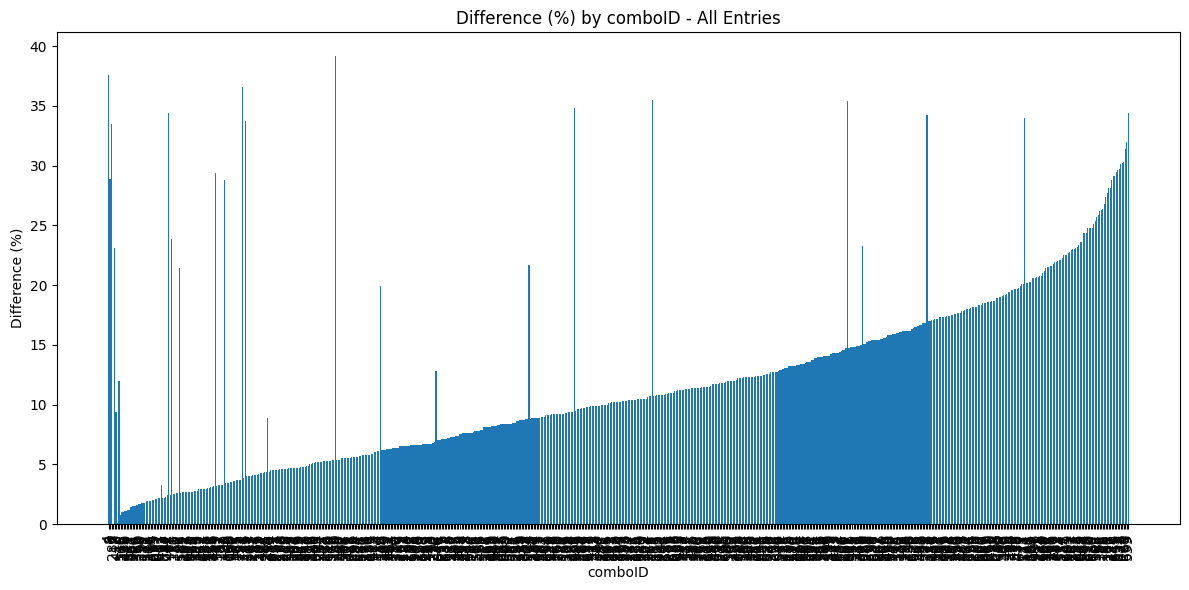

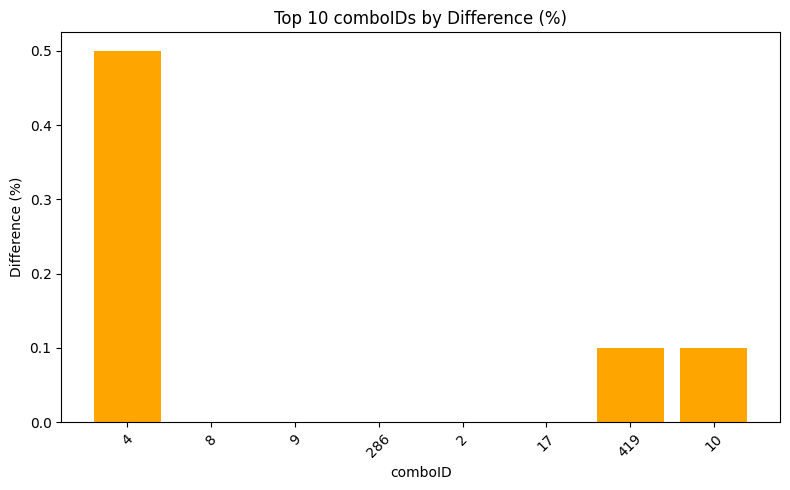

In [3]:

import pandas as pd
import matplotlib.pyplot as plt


data = pd.read_csv("C:/Users/felix/OneDrive/McGill Master Work/0.5 - Summer 25/MGSC 670 - Revenue Management/Assignement/Retail_Mardown_Game/Retail_Mardown_Game/01_BACKUP-FINAL/outcome_Felix_1.csv")

# Sort by "Difference (%)" in ascending order
data_sorted = data.sort_values(by="Difference (%)", ascending=True)

# Plot bar graph for all entries
plt.figure(figsize=(12, 6))
plt.bar(data_sorted["comboID"].astype(str), data_sorted["Difference (%)"])
plt.xticks(rotation=90)
plt.xlabel("comboID")
plt.ylabel("Difference (%)")
plt.title("Difference (%) by comboID - All Entries")
plt.tight_layout()
plt.show()

# Plot bar graph for top 10 entries with highest Difference (%)
top10 = data_sorted.sort_values(by="Difference (%)", ascending=True).head(10)

plt.figure(figsize=(8, 5))
plt.bar(top10["comboID"].astype(str), top10["Difference (%)"], color='orange')
plt.xticks(rotation=45)
plt.xlabel("comboID")
plt.ylabel("Difference (%)")
plt.title("Top 10 comboIDs by Difference (%)")
plt.tight_layout()
plt.show()


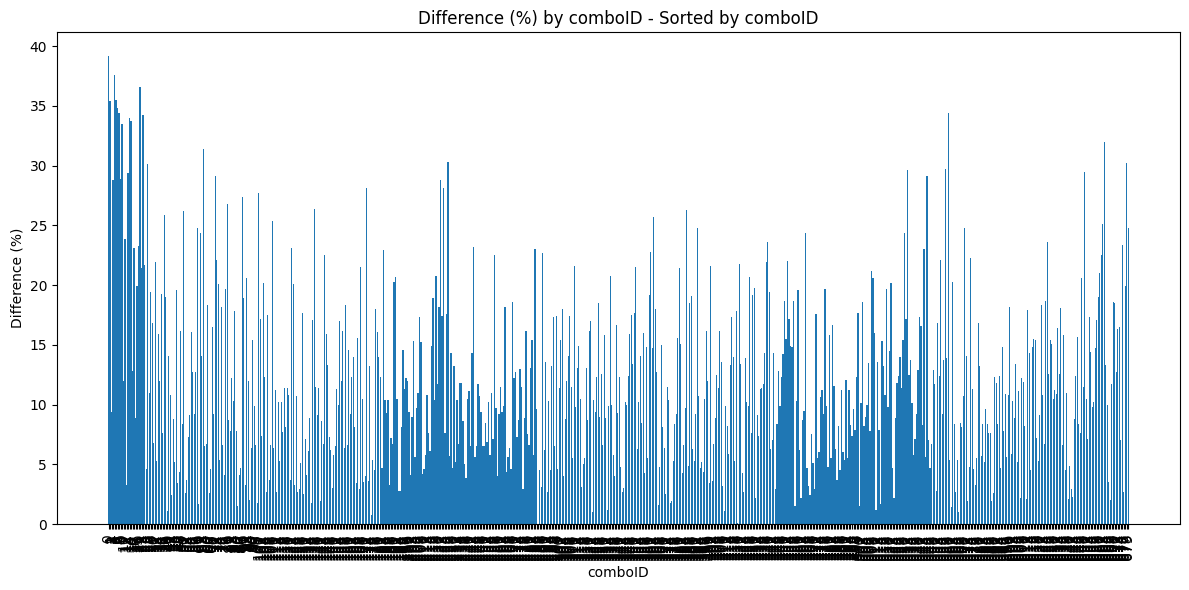

In [4]:
# Sort by comboID in ascending order
data_sorted_by_id = data.sort_values(by="comboID", ascending=True)

# Plot bar graph for all entries sorted by comboID
plt.figure(figsize=(12, 6))
plt.bar(data_sorted_by_id["comboID"].astype(str), data_sorted_by_id["Difference (%)"])
plt.xticks(rotation=90)
plt.xlabel("comboID")
plt.ylabel("Difference (%)")
plt.title("Difference (%) by comboID - Sorted by comboID")
plt.tight_layout()
plt.show()

In [18]:
combos_df = pd.read_csv('combos_df.csv')
combos_df.rename(columns={"combo_number": "comboID"}, inplace=True)


# print("Combos DataFrame:")
display(combos_df)

# print("\nOutcome DataFrame:")
# display(data)

,comboID,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,0,60,60,60,60,60,60,60,60,60,60,60,60,60,60,60
1,1,60,60,60,60,60,60,60,60,60,60,60,60,60,60,54
2,2,60,60,60,60,60,60,60,60,60,60,60,60,60,60,48
3,3,60,60,60,60,60,60,60,60,60,60,60,60,60,60,36
4,4,60,60,60,60,60,60,60,60,60,60,60,60,60,54,54
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
675,675,60,48,48,48,48,36,36,36,36,36,36,36,36,36,36
676,676,60,48,48,48,36,36,36,36,36,36,36,36,36,36,36
677,677,60,48,48,36,36,36,36,36,36,36,36,36,36,36,36
678,678,60,48,36,36,36,36,36,36,36,36,36,36,36,36,36


In [20]:
import pandas as pd

# Use string versions of column names
cols = [str(i) for i in range(1, 16)]

# Join the values in columns '1' to '15' into a comma-separated string per row
combos_df['all_values'] = combos_df[cols].astype(str).agg(','.join, axis=1)

# Flatten all values across all rows
all_values_flat = [item for row in combos_df['all_values'] for item in row.split(',')]

unique_combos_count = combos_df['all_values'].nunique()

print(f"Number of unique combinations: {unique_combos_count}")



Number of unique combinations: 680


In [8]:
# Merge the DataFrames on 'comboID'
merged_df = pd.merge(data, combos_df, on="comboID")

# Drop the specified columns
columns_to_drop = ["Simulation Number", "comboID", "Your revenue", "Perfect foresight strategy"]
merged_df.drop(columns=columns_to_drop, inplace=True)


topmerged10 = merged_df.sort_values(by="Difference (%)", ascending=True).head(10)
print("\nMerged DataFrame:")
display(topmerged10)



Merged DataFrame:


,Difference (%),1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
71,0.0,60,60,60,60,60,60,60,60,60,60,60,60,60,54,54
65,0.0,60,60,60,60,60,60,60,60,60,60,60,60,60,48,36
76,0.0,60,60,60,60,60,60,60,60,60,60,60,60,60,36,36
353,0.0,60,60,60,60,54,54,54,54,54,54,54,54,54,54,54
33,0.0,60,60,60,60,60,60,60,60,60,60,60,60,60,48,36
17,0.0,60,60,60,60,60,60,60,60,60,60,60,60,48,48,36
37,0.0,60,60,60,60,60,60,60,60,60,60,60,60,60,60,48
486,0.1,60,60,60,54,54,48,48,48,48,48,48,48,48,48,48
10,0.1,60,60,60,60,60,60,60,60,60,60,60,60,54,54,54
61,0.5,60,60,60,60,60,60,60,60,60,60,60,60,60,54,54
